In [1]:
import xgboost as xgb
import pandas as pd

In [12]:
fastball = xgb.XGBRegressor()
fastball.load_model('fastball_final_model.json')
offspeed = xgb.XGBRegressor()
offspeed.load_model('offspeed_final_model.json')

In [37]:
df = pd.read_csv("Y:/departments/research_and_development/baseball_operations/clayton_goodiez/csv/deltaRE_og_description.csv")

In [38]:
df = df.loc[(df['description'] == 'called_strike') | (df['description'] == 'ball')].copy() # only called strikes and balls
df['is_strike'] = df['description'].map({'called_strike': 1, 'ball': 0}) # convert to binary
df['p_throws'] = df['p_throws'].map({'R': 1, 'L': 0}) # convert to binary
df['stand'] = df['stand'].map({'R': 1, 'L': 0}) # convert to binary
#map pitch types to numbers
pitch_type_dict = {'FF': 1, 'SL': 2, 'CH': 2, 'CU': 2, 'SI': 1, 'FC': 1, 'KC': 2, 'FS': 2, 'KN': 2, 'EP': 2, 'FO': 2, 'SC': 2, 'ST': 2, 'FA': 1, 'SV': 2, 'CS': 2, 'nan': 17}
df['pitch_type_dict'] = df['pitch_type'].map(pitch_type_dict)
df['likely_strike'] = ((df['plate_x'].abs() <= .708) &
                          (df['plate_z'] <= df['sz_top']) &
                            (df['plate_z'] >= df['sz_bot'])).astype(int)


In [39]:
heaters_2023 = df[df['pitch_type_dict'] == 1].copy()
offspeed_2023 = df[df['pitch_type_dict'] == 2].copy()
# Select only the features you used for training the models
features = ['zone', 'stand', 'strikes', 'plate_x', 'plate_z',  'likely_strike']

# Convert DataFrame to DMatrix
dmatrix_heaters_2023 = xgb.DMatrix(heaters_2023[features])
dmatrix_offspeed_2023 = xgb.DMatrix(offspeed_2023[features])

# Make predictions
heaters_2023['prediction'] = fastball.predict(heaters_2023[features])
offspeed_2023['prediction'] = offspeed.predict(offspeed_2023[features])

In [40]:
complete = pd.concat([heaters_2023, offspeed_2023], axis=0)
complete['probability_added'] = 0
# Correct the conditions and assignment for 'probability_added'
condition1 = (complete['is_strike'] == 1)
complete.loc[condition1, 'probability_added'] = 1 - complete.loc[condition1, 'prediction']

condition2 = (complete['is_strike'] == 0)
complete.loc[condition2, 'probability_added'] = -1 + complete.loc[condition2, 'prediction']

# Correct the conditions and assignment for 'probability_added'
condition1 = (complete['is_strike'] == 1)
complete.loc[condition1, 'probability_added'] = 1 - complete.loc[condition1, 'prediction']

condition2 = (complete['is_strike'] == 0)
complete.loc[condition2, 'probability_added'] = 0 + complete.loc[condition2, 'prediction']


C:\Users\clayton.thompson\AppData\Local\Temp\ipykernel_14168\552646272.py:5: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.00489807 0.18568712 0.01950896 ... 0.00533003 0.00383472 0.10790265]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  complete.loc[condition1, 'probability_added'] = 1 - complete.loc[condition1, 'prediction']


In [41]:
players = pd.read_csv("Y:/departments/research_and_development/baseball_operations/clayton_goodiez/csv/players_query.csv")

completed = complete.merge(players, left_on='fielder_2', right_on='mlb_id', how='left')

strike_probs = completed.loc[completed['probability_added'] != 0].copy()

strike_probs['framing_runs'] = (strike_probs['deltaRE'] * -1) * strike_probs['probability_added'].abs()

In [42]:
print(strike_probs.groupby('mlb_name')['framing_runs'].sum().sort_values(ascending = True).head(10))

mlb_name
Carlos Perez       -4.319193
Elias Diaz         -3.553818
Keibert Ruiz       -2.894425
Jose Herrera       -2.628615
David Fry          -2.508127
Logan OHoppe       -2.048969
Tyler Stephenson   -1.978379
Tom Murphy         -1.681384
Riley Adams        -1.542744
Tyler Soderstrom   -1.266217
Name: framing_runs, dtype: float64


# Initial Leaderboard

In [43]:
import matplotlib.pyplot as plt
import seaborn as sns

In [49]:
# Step 1: Filter the 'strike_probs' DataFrame to create the 'framing' DataFrame
framing = strike_probs.loc[
    ((strike_probs['prediction'] >= .5) & (strike_probs['is_strike'] == 0)) |
    ((strike_probs['prediction'] <= .65) & (strike_probs['is_strike'] == 1))
].copy()

# Step 2: Calculate the counts of occurrences for each player
framing['count'] = framing.groupby('mlb_name')['mlb_name'].transform('count')

# Step 3: Calculate the average framing runs from the 'framing' DataFrame
average_framing_runs = framing['framing_runs'].mean()

# Step 4: Calculate the deviation from the average for each player in the 'framing' DataFrame
framing['framing_runs_above_avg'] = framing['framing_runs'] - average_framing_runs

# Step 5: Prepare the data for the heatmap, including the counts
heatmap_data = framing.groupby('mlb_name').agg({
    'framing_runs_above_avg': 'sum', 
    'count': 'first'  # We can use 'first' because all counts for a player will be the same
}).reset_index()

# Filter out the players with fewer than 200 occurrences
filtered_heatmap_data = heatmap_data[heatmap_data['count'] >= 200].sort_values('framing_runs_above_avg', ascending=False)

C:\Users\clayton.thompson\AppData\Local\Temp\ipykernel_14168\3769378277.py:52: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, .9, 1])


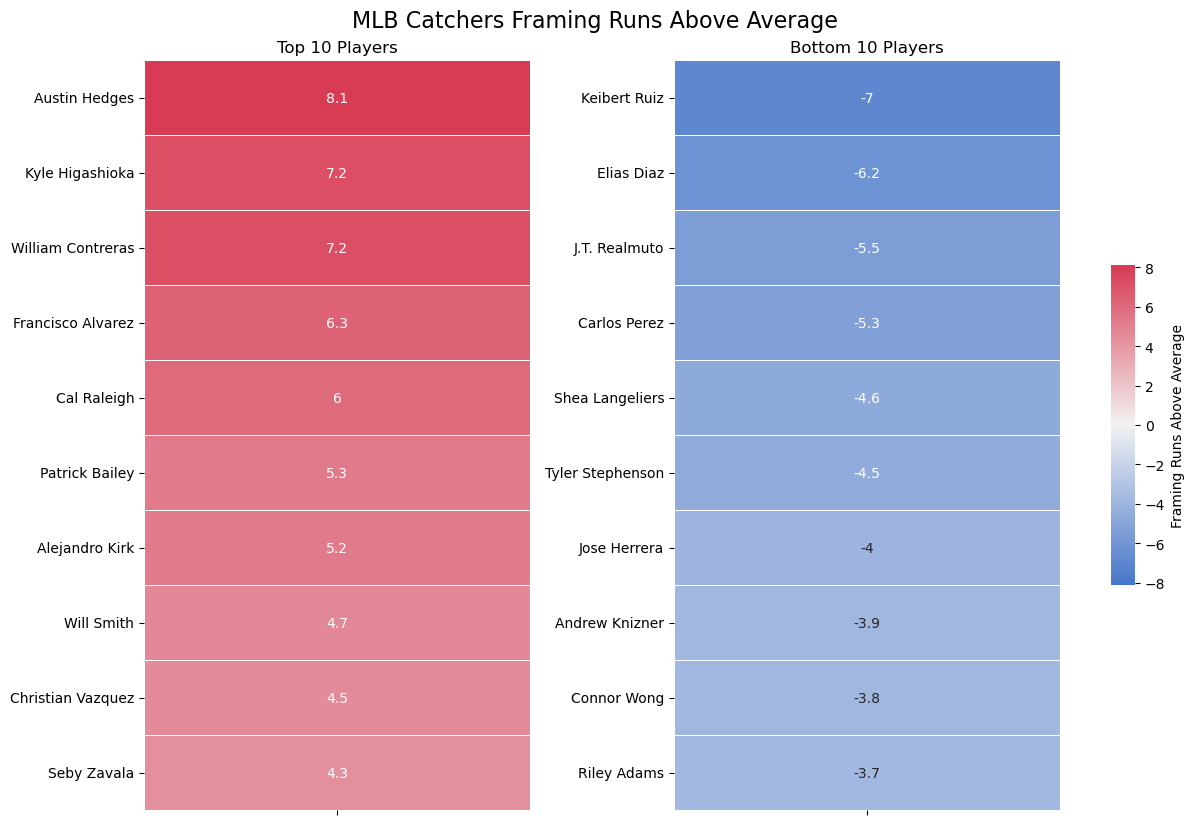

In [74]:
# Sort the players to get the top and bottom 10
top_10 = heatmap_data.sort_values(by='framing_runs_above_avg', ascending=False).head(10)
bottom_10 = heatmap_data.sort_values(by='framing_runs_above_avg').head(10)

# Find the max absolute value for the color scale
max_value_for_scale = max(top_10['framing_runs_above_avg'].max(), abs(bottom_10['framing_runs_above_avg'].min()))

# Set up the matplotlib figure with two subplots
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 8))

# Create a common color bar scale based on the combined range of the top and bottom 10 players
vmin = -max_value_for_scale
vmax = max_value_for_scale

# Reverse the colormap to have red for positive and blue for negative
cmap = sns.diverging_palette(255, 7, as_cmap=True)

# Generate the heatmap for the top 10 with a fixed scale
sns.heatmap(
    top_10.set_index('mlb_name')[['framing_runs_above_avg']], 
    cmap=cmap, 
    linewidths=.5, 
    annot=True, 
    vmin=vmin, vmax=vmax, 
    cbar=False, 
    ax=ax1
)

ax1.set_title('Top 10 Players')
ax1.set_xticklabels([])  # Remove x-axis tick labels
ax1.set_yticklabels(top_10['mlb_name'], rotation=0)

# Generate the heatmap for the bottom 10 with a fixed scale
sns.heatmap(
    bottom_10.set_index('mlb_name')[['framing_runs_above_avg']], 
    cmap=cmap, 
    linewidths=.5, 
    annot=True, 
    vmin=vmin, vmax=vmax, 
    cbar_ax=fig.add_axes([.93, .3, .02, .4]), 
    cbar_kws={'label': 'Framing Runs Above Average'},
    ax=ax2
)

ax2.set_title('Bottom 10 Players')
ax2.set_xticklabels([])  # Remove x-axis tick labels
ax1.set_ylabel('')  # Remove x-axis label
ax2.set_ylabel('')  # Remove x-axis label
ax2.set_yticklabels(bottom_10['mlb_name'])  # Ensure player names are on the y-axis

# Improve layout
plt.tight_layout(rect=[0, 0, .9, 1])

fig.suptitle('MLB Catchers Framing Runs Above Average', fontsize=16, y=1.02)

# Show the plot
plt.show()